In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x, activation=1)


    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, variables)
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step {step}: Loss={loss:.4f}, Accuracy={acc:.4f}")


Step 100: Loss=315.8575, Accuracy=0.6992
Step 200: Loss=179.7270, Accuracy=0.7969
Step 300: Loss=163.1085, Accuracy=0.8203
Step 400: Loss=190.2863, Accuracy=0.7695
Step 500: Loss=155.7043, Accuracy=0.8242
Step 600: Loss=109.2839, Accuracy=0.8672
Step 700: Loss=132.6381, Accuracy=0.8477
Step 800: Loss=104.5303, Accuracy=0.8906
Step 900: Loss=121.8242, Accuracy=0.8711
Step 1000: Loss=103.9332, Accuracy=0.8789
Step 1100: Loss=104.7571, Accuracy=0.8672
Step 1200: Loss=72.1942, Accuracy=0.9219
Step 1300: Loss=85.6110, Accuracy=0.9141
Step 1400: Loss=74.4822, Accuracy=0.8984
Step 1500: Loss=100.1338, Accuracy=0.9141
Step 1600: Loss=69.7501, Accuracy=0.9141
Step 1700: Loss=70.1392, Accuracy=0.9141
Step 1800: Loss=78.3794, Accuracy=0.9297
Step 1900: Loss=55.2651, Accuracy=0.9375
Step 2000: Loss=90.5869, Accuracy=0.9062
Step 2100: Loss=68.5237, Accuracy=0.9102
Step 2200: Loss=73.3359, Accuracy=0.9180
Step 2300: Loss=62.5603, Accuracy=0.9297
Step 2400: Loss=68.3695, Accuracy=0.9180
Step 2500: Lo

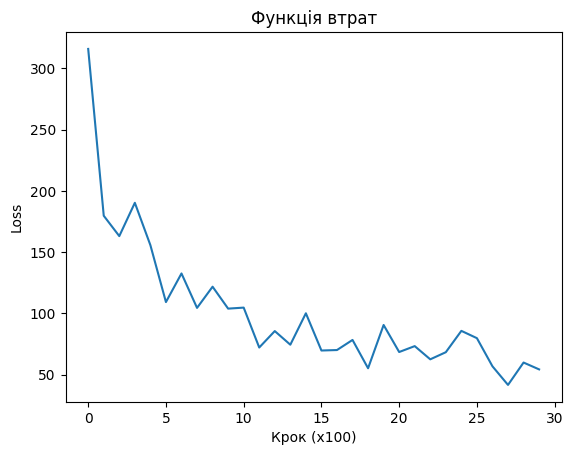

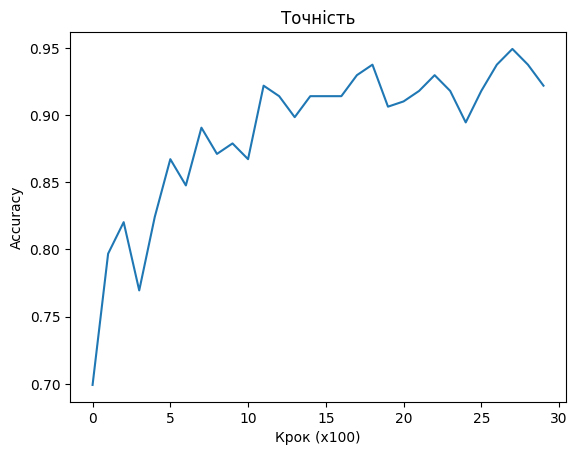

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history)
plt.xlabel("Крок (x100)")
plt.ylabel("Loss")
plt.title("Функція втрат")
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history)
plt.xlabel("Крок (x100)")
plt.ylabel("Accuracy")
plt.title("Точність")
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print("Точність на тестових даних:", test_acc.numpy())
# Тестування моделі на тестових даних
from sklearn.metrics import classification_report

y_pred = tf.argmax(test_pred, axis=1)
print(classification_report(y_test, y_pred))

Точність на тестових даних: 0.9049
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.89      0.89      1010
           4       0.88      0.90      0.89       982
           5       0.91      0.84      0.88       892
           6       0.94      0.91      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.80      0.90      0.85       974
           9       0.88      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.91     10000



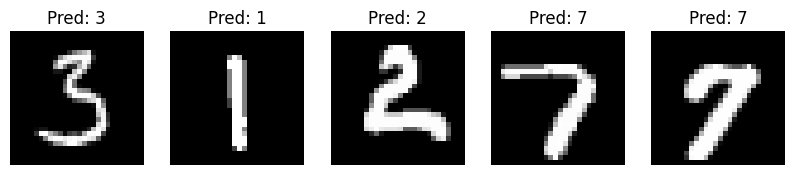

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

indexes = random.sample(range(len(x_test)), 5)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indexes):
    image = x_test[idx].reshape(28, 28)
    pred = tf.argmax(neural_net(tf.expand_dims(x_test[idx], 0)), axis=1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Pred: {pred.numpy()[0]}")
    plt.axis("off")

plt.show()


Висновки

У роботі було реалізовано повнозв’язну нейронну мережу для розпізнавання рукописних цифр датасету MNIST. Під час навчання спостерігається зменшення функції втрат та зростання точності, що підтверджує коректність процесу навчання моделі.

На тестовій вибірці мережа досягла точності 0.9049, що свідчить про достатньо хорошу узагальнюючу здатність. Найкращі результати отримано для класів 1, 0 та 6, тоді як найбільше помилок виникає при розпізнаванні цифр зі схожою формою, наприклад 8 та 5.

Перевірка на випадкових зображеннях показала, що нейронна мережа в більшості випадків робить правильні передбачення. 